In [13]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l


In [2]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d21.synthetic_data(true_w, true_b, n_train)
train_iter = d21.load_array(train_data, batch_size)
test_data = d21.synthetic_data(true_w, true_b, n_test)
test_iter = d21.load_array(test_data, batch_size, is_train=False)


In [3]:
def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]


In [4]:
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2


In [16]:
def train(lambd):
    w, b = init_params()
    
    net, loss = lambda X: (d2l.linreg(X, w, b), d2l.squared_loss)
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', xscale='log', yscale='log', 
                            xlim=[5, num_epochs], legend=['train', 'test'])
    
    for epoch in range(num_epochs):
        for X, y in train_iter:
            #with torch.enable_grad():
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)
        
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, 
                         d2l.evaluate_loss(net, train_iter, loss), 
                         d2l.evaluate_loss(net, test_iter, loss))
    print('w的L2范数是:', torch.norm(w).item())


RuntimeError: mat1 and mat2 shapes cannot be multiplied (5x1 and 200x1)

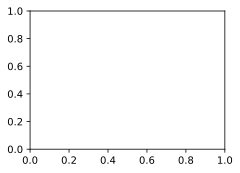

In [17]:
train(lambd=0)

In [24]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    
    # 初始化网络参数
    for param in net.parameters():
        param.data.normal_()
    
    loss = nn.MSELoss()
    num_epochs, lr = 100, 0.003
    
    # 设置优化器
    trainer = torch.optim.SGD([{
        "params": net[0].weight,
        'weight_decay': wd
    }, {
        "params": net[0].bias}], lr=lr)
    
    # 可视化器
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', xscale='log', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with torch.enable_grad():
                trainer.zero_grad()  # 清空梯度
                l = loss(net(X), y)  # 计算损失
                l.backward()  # 反向传播
                trainer.step()  # 更新参数



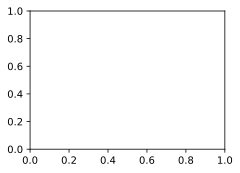

In [25]:
train_concise(wd=0)

# Dropout

In [28]:
import torch
from torch import nn
from d2l import torch as d2l

def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    if dropout == 1:
        return torch.zeros_like(X)
    if dropout == 0:
        return X
    mask = (torch.randn(X.shape) > dropout).float()
    return mask * X / (1.0 - dropout)


In [29]:
x = torch.arange(16, dtype=torch.float32).reshape((2, 8))
print(x)
print(dropout_layer(x, 0.))
print(dropout_layer(x, 0.5))
print(dropout_layer(x, 1.))


tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0., 14.],
        [ 0., 18.,  0.,  0., 24., 26.,  0.,  0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


In [30]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256
dropout1, dropout2 = 0.2, 0.5

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens1, num_hiddens2, is_training=True):
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.training = is_training
        self.lin1 = nn.Linear(num_inputs, num_hiddens1)
        self.lin2 = nn.Linear(num_hiddens1, num_hiddens2)
        self.lin3 = nn.Linear(num_hiddens2, num_outputs)
        self.relu = nn.ReLU()

    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((-1, self.num_inputs))))
        if self.training == True:
            H1 = dropout_layer(H1, dropout1)
        H2 = self.relu(self.lin2(H1))
        if self.training == True:
            H2 = dropout_layer(H2, dropout2)
        out = self.lin3(H2)
        return out

net = Net(num_inputs, num_outputs, num_hiddens1, num_hiddens2)


In [31]:
num_epochs, lr, batch_size = 10, 0.5, 256
loss = nn.CrossEntropyLoss()
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)


AttributeError: module 'd2l.torch' has no attribute 'train_ch3'

In [ ]:
net = nn.Sequential(
    nn.Flatten(), nn.Linear(784, 256), nn.ReLU(),
    nn.Dropout(dropout1), nn.Linear(256, 256), nn.ReLU(),
    nn.Dropout(dropout2), nn.Linear(256, 10)
)

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);
